# Implementação do Random Forest

In [1]:
TRAINING_DATASET_SOURCE = '../training_data.csv'  # Since we are one directory up, we should go down one directory to import the datasets
TEST_DATASET_SOURCE = '../test_data.csv'

In [2]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from pandas import DataFrame
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

# Definição dos dados de teste e de treino

In [3]:
print(train_df.shape, test_df.shape)

(5000, 13) (1206, 12)


In [4]:
train_df['incidents'].value_counts()

None         2028
High         1073
Low           718
Very_High     603
Medium        578
Name: incidents, dtype: int64

In [5]:
#count_class0, count_class1, count_class2, count_class3, count_class4 = train_df['incidents'].value_counts().to_frame()

incidents_count = train_df['incidents'].value_counts()

max_count = incidents_count.max()

print('Max value count:', max_count)

df_classes = []
for category, counts in zip(incidents_count.index, incidents_count):
    #print(category, counts)
    df_classes.append(train_df[train_df['incidents'] == category])

df_classes_over = []

for category in df_classes:
    df_classes_over.append(category.sample(max_count, replace=True))

df_test_over = pd.concat(df_classes_over, axis=0)

print(df_test_over['incidents'].value_counts())


Max value count: 2028
None         2028
High         2028
Low          2028
Very_High    2028
Medium       2028
Name: incidents, dtype: int64


In [6]:
X = df_test_over.drop(['incidents'], axis=1)
y = df_test_over['incidents']

all_features = X.columns.tolist()

In [7]:
X

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
4913,Guimaraes,UNDEFINED,0,",",2021-12-22 23:00,DARK,14.0,1014.0,81.0,2.0,0.0,chuva fraca
4714,Guimaraes,UNDEFINED,0,",",2021-01-18 06:00,DARK,5.0,1027.0,81.0,4.0,0.0,Sem Chuva
1503,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-04 06:00,LIGHT,15.0,1019.0,92.0,0.0,0.0,Sem Chuva
4686,Guimaraes,UNDEFINED,0,",",2021-02-03 12:00,LIGHT,13.0,1011.0,83.0,4.0,0.0,Sem Chuva
1340,Guimaraes,UNDEFINED,0,"N101,N101",2021-12-02 03:00,DARK,8.0,1017.0,93.0,4.0,0.0,chuva fraca
...,...,...,...,...,...,...,...,...,...,...,...,...
2140,Guimaraes,UNDEFINED,577,"N101,N101,N101,N101,N101,N101,N101",2021-11-27 13:00,LIGHT,11.0,1015.0,46.0,6.0,0.0,chuva fraca
612,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-20 06:00,LIGHT,13.0,1009.0,92.0,2.0,0.0,Sem Chuva
2661,Guimaraes,MAJOR,1102,"N105,N101,N101,N101,N101,N105,N101,N101",2021-11-19 20:00,DARK,14.0,1021.0,67.0,2.0,0.0,Sem Chuva
1818,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-16 23:00,DARK,18.0,1012.0,83.0,1.0,0.0,Sem Chuva


### Obtenção das features numericas e categoricas

In [8]:
dropped_columns = ['city_name', 'avg_precipitation', 'magnitude_of_delay', 'record_date']

numerical_features = [column for column, dtype in zip(X.columns, X.dtypes)
                      if dtype.kind in ['i', 'f'] and column not in dropped_columns]

categorical_features = [column for column, dtype in zip(X.columns, X.dtypes)
                        if
                        dtype.kind not in ['i', 'f'] and column != 'affected_roads' and column not in dropped_columns]

special_features = ['affected_roads']

### Divisão dos dados em dados de teste e treino

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2000)

#### Criação de steps para tratar da remoção de features


In [10]:
class ColumnsRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame, y=None):
        X_ = X.copy()

        X_.drop(columns=dropped_columns, inplace=True)

        return X_

#### Criação de steps para tratar da feature `affected_roads`

In [11]:
# noinspection PyPep8Naming,PyMethodMayBeStatic,PyShadowingNames
class AffectedRoadsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: DataFrame, y=None):
        X_ = X.copy()

        road_quantity = []
        for line in X_['affected_roads']:
            unique_roads = set(str(line).split(','))
            valid_roads = [elem for elem in unique_roads if elem != '']
            count = len(valid_roads)
            road_quantity.append(count)

        X_['num_affected_roads'] = road_quantity
        X_.drop(columns=['affected_roads'], inplace=True)

        imputer = SimpleImputer(strategy='median')
        scaler = MinMaxScaler()

        imputer.fit(X_)
        X_ = imputer.transform(X_)

        scaler.fit(X_)
        X_ = scaler.transform(X_)

        return X_

### Pipeline de preparação de dados

In [12]:
preprocessor = make_column_transformer(
    (make_pipeline(
        AffectedRoadsTransformer()
    ), special_features),

    (make_pipeline(
        ColumnsRemovalTransformer()
    ), dropped_columns),

    (make_pipeline(
        SimpleImputer(strategy='median'),
        MinMaxScaler(),
    ), numerical_features),

    (make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(categories='auto', handle_unknown='ignore'),
    ), categorical_features),
)

In [13]:
X_train

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
1055,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-03-30 08:00,LIGHT,13.0,1020.0,63.0,4.0,0.0,Sem Chuva
3082,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-12-10 05:00,DARK,12.0,1022.0,94.0,0.0,0.0,Sem Chuva
505,Guimaraes,UNDEFINED,216,"N101,N101,N101,N101,N101,N105",2021-03-23 12:00,LIGHT,16.0,1024.0,77.0,3.0,0.0,Sem Chuva
3014,Guimaraes,UNDEFINED,315,"N101,N101,N101,N101,N101,N101,N101",2021-09-14 10:00,LIGHT,21.0,1010.0,76.0,0.0,0.0,Sem Chuva
1313,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-03 04:00,DARK,10.0,1019.0,91.0,0.0,0.0,Sem Chuva
...,...,...,...,...,...,...,...,...,...,...,...,...
4462,Guimaraes,UNDEFINED,669,"N101,N101,N101,N101,N101,N101,IC5",2021-12-02 12:00,LIGHT,10.0,1021.0,68.0,2.0,0.0,Sem Chuva
2903,Guimaraes,UNDEFINED,0,",",2021-01-22 10:00,LIGHT,8.0,1013.0,92.0,4.0,0.0,chuva fraca
4308,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-06-27 21:00,DARK,14.0,1020.0,77.0,2.0,0.0,Sem Chuva
4262,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-04-14 00:00,DARK,13.0,1019.0,81.0,0.0,0.0,Sem Chuva


In [14]:
preprocessor.fit(X_train)
preprocessor.transform(X_train)

array([[0.14285714, 0.        , 0.35294118, ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.        , 0.32352941, ..., 0.        , 0.        ,
        0.        ],
       [0.28571429, 0.00694914, 0.44117647, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14285714, 0.        , 0.38235294, ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.        , 0.35294118, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.35294118, ..., 0.        , 0.        ,
        0.        ]])

In [15]:
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif

preprocessor_best = make_pipeline(preprocessor, VarianceThreshold())#, SelectKBest(f_classif, k='all'))

In [16]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators=100))

In [17]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

0.9978867286559594

In [18]:
RF_Model.score(X_test, y_test)

0.923405654174885

## Hyperparameter Tuning

In [26]:
import numpy as np

n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=5)]

max_features = ['sqrt']

max_depth = [2, 6, 12, 20, 30, 40, 50]

min_samples_split = [2, 5, 30]

min_samples_leaf = [1, 2, 50]

bootstrap = [True, False]

criterions = ["gini", "entropy", "log_loss"]

In [27]:
param_grid = {
    'randomforestclassifier__n_estimators': n_estimators,
    'randomforestclassifier__max_features': max_features,
    'randomforestclassifier__max_depth': max_depth,
    'randomforestclassifier__min_samples_split': min_samples_split,
    'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    'randomforestclassifier__bootstrap': bootstrap,
    'randomforestclassifier__criterion': criterions
}

param_grid

{'randomforestclassifier__n_estimators': [10, 132, 255, 377, 500],
 'randomforestclassifier__max_features': ['sqrt'],
 'randomforestclassifier__max_depth': [2, 6, 12, 20, 30, 40, 50],
 'randomforestclassifier__min_samples_split': [2, 5, 30],
 'randomforestclassifier__min_samples_leaf': [1, 2, 50],
 'randomforestclassifier__bootstrap': [True, False],
 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']}

In [28]:
from sklearn import metrics

print(metrics.get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 

In [29]:
rf_RandomGrid = RandomizedSearchCV(estimator=RF_Model, param_distributions=param_grid, cv=20, verbose=3, n_jobs=-1,
                                   n_iter=5, scoring='balanced_accuracy')

In [30]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 20 folds for each of 5 candidates, totalling 100 fits
CPU times: total: 625 ms
Wall time: 20 s


RandomizedSearchCV(cv=20,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('affectedroadstransformer',
                                                                                                                 AffectedRoadsTransformer())]),
                                                                                                ['affected_roads']),
                                                                                               ('pipeline-2',
                                                                                                Pipeline(steps=[('columnsremovaltransformer',
                                                                                                                 ColumnsRemovalTransformer())]),
                                                                                                ['city_name',
                                                                                                 'avg_pr...
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy',
                                                                              'log_loss'],
                                        'randomforestclassifier__max_depth': [2,
                                                                              6,
                                                                              12,
                                                                              20,
                                                                              30,
                                                                              40,
                                                                              50],
                                        'randomforestclassifier__max_features': ['sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     50],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      30],
                                        'randomforestclassifier__n_estimators': [10,
                                                                                 132,
                                                                                 255,
                                                                                 377,
                                                                                 500]},
                   scoring='balanced_accuracy', verbose=3)

In [31]:
rf_RandomGrid.score(X_train, y_train)

0.9978736853350766

In [32]:
rf_RandomGrid.best_score_

0.9188222589889579

In [33]:
rf_RandomGrid.best_params_

{'randomforestclassifier__n_estimators': 10,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__bootstrap': False}

In [34]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('affectedroadstransformer',
                                                                                    AffectedRoadsTransformer())]),
                                                                   ['affected_roads']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('columnsremovaltransformer',
                                                                                    ColumnsRemovalTransformer())]),
                                                                   ['city_name',
                                                                    'avg_precipitation',
                                                                    'magnitude_of_delay',
                                                                    '...
                                                                  ('pipeline-4',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['luminosity',
                                                                    'avg_rain'])])),
                                 ('variancethreshold', VarianceThreshold())])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=30, n_estimators=10))])

In [35]:
print(f'Train: {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test: {rf_RandomGrid.score(X_test, y_test):.3f}')

Train: 0.998
Test: 0.930


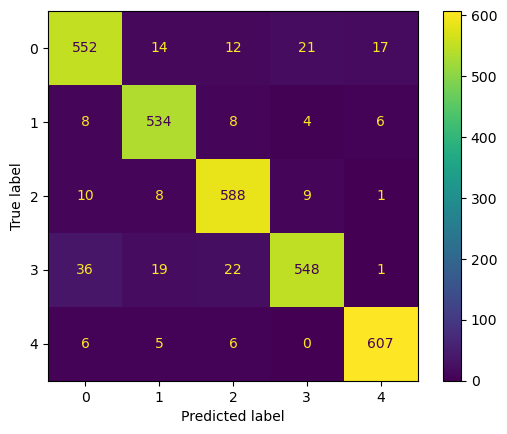

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = rf_RandomGrid.predict(X_test)

cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()

### Obtenção das previsões do dataset de submissão

In [37]:
X = test_df.copy()

preprocessor.fit(X)
preprocessor.transform(X)

predictions = rf_RandomGrid.predict(X)
predictions_df = pd.DataFrame(predictions)
predictions_df.index += 1
predictions_df.to_csv("../submission.csv", header=['Incidents'], index_label='RowId')